### **NEW CODE**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import vgg16
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils


In [ ]:
batch_size = 32

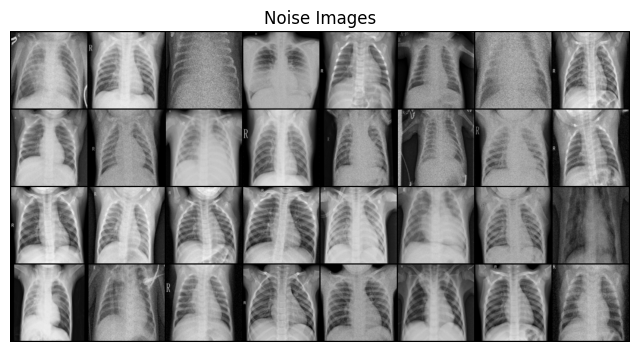

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
noisy_root_dir = "/content/drive/MyDrive/CS 415 Computer Vision/CV CS 415/chest_xray/processed_train_noisy"
noise_free_root_dir = "/content/drive/MyDrive/CS 415 Computer Vision/CV CS 415/chest_xray/processed_train"
# Define transformations (resize and normalize)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 64x64
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),        # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range

])

# Load datasets
clean_dataset = datasets.ImageFolder(noise_free_root_dir, transform=transform)
noisy_dataset = datasets.ImageFolder(noisy_root_dir, transform=transform)

# DataLoaders for batching
clean_loader = DataLoader(clean_dataset, batch_size=batch_size, shuffle=True)
noisy_loader = DataLoader(noisy_dataset, batch_size=batch_size, shuffle=True)


# Plot some Noise images
noise_batch = next(iter(noisy_loader))
# Rescale the images from [-1, 1] to [0, 1]
# Applying the reversal normalization to each image in the batch
grid_img = vutils.make_grid(noise_batch[0].to(device)[:64], padding=2, normalize=True)
#grid_img = (grid_img + 1) / 2  # Revert to [0, 1] range
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Noise Images")
plt.imshow(np.transpose(grid_img.cpu(), (1, 2, 0)))  # Convert to HWC format for plotting
plt.show()

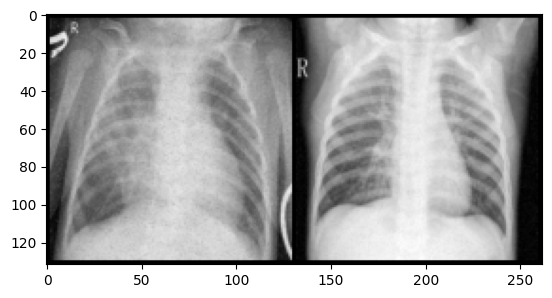

In [ ]:
plt.imshow(np.transpose(vutils.make_grid(noise_batch[0].to(device)[:2], padding=2, normalize=True).cpu(), (1, 2, 0)))

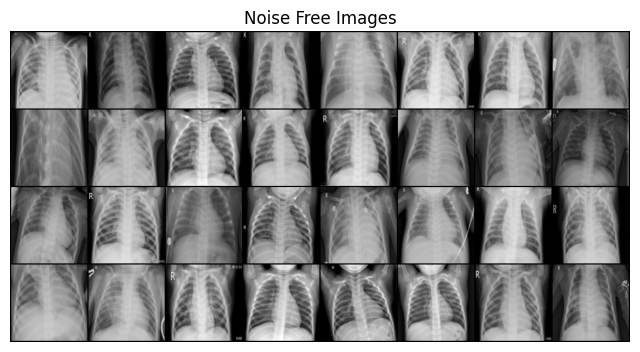

In [ ]:
# Plot some Noise free images
real_batch = next(iter(clean_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Noise Free Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # Input: (1, 64, 64)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Upsample
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Normalize output to [-1, 1]
        )

    def forward(self, x):
        return self.main(x)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [ ]:
!pip install torchinfo


In [ ]:
from torchinfo import summary

# Initialize the models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Print summary for the Generator
# print("Generator Model Summary:")
# summary(generator, input_size=(1, 1, 64, 64))  # Assuming input is (batch_size, channels, height, width)

# Print summary for the Discriminator
print("\nDiscriminator Model Summary:")
summary(discriminator, input_size=(1, 1, 64, 64))



Discriminator Model Summary:


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,088
│    └─LeakyReLU: 2-2                    [1, 64, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 128, 16, 16]          131,200
│    └─BatchNorm2d: 2-4                  [1, 128, 16, 16]          256
│    └─LeakyReLU: 2-5                    [1, 128, 16, 16]          --
│    └─Conv2d: 2-6                       [1, 256, 8, 8]            524,544
│    └─BatchNorm2d: 2-7                  [1, 256, 8, 8]            512
│    └─LeakyReLU: 2-8                    [1, 256, 8, 8]            --
│    └─Flatten: 2-9                      [1, 16384]                --
│    └─Linear: 2-10                      [1, 1]                    16,385
│    └─Sigmoid: 2-11                     [1, 1]                   

In [ ]:
summary(generator, input_size=(1, 1, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 64, 64]            --
├─Sequential: 1-1                        [1, 1, 64, 64]            --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,088
│    └─LeakyReLU: 2-2                    [1, 64, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 128, 16, 16]          131,200
│    └─BatchNorm2d: 2-4                  [1, 128, 16, 16]          256
│    └─LeakyReLU: 2-5                    [1, 128, 16, 16]          --
│    └─Conv2d: 2-6                       [1, 256, 8, 8]            524,544
│    └─BatchNorm2d: 2-7                  [1, 256, 8, 8]            512
│    └─LeakyReLU: 2-8                    [1, 256, 8, 8]            --
│    └─ConvTranspose2d: 2-9              [1, 128, 16, 16]          524,416
│    └─BatchNorm2d: 2-10                 [1, 128, 16, 16]          256
│    └─ReLU: 2-11                        [1, 128, 16, 16]       

In [ ]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
lr = 0.0002
beta1 = 0.5
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss functions
adversarial_loss = nn.BCELoss()  # Binary Cross Entropy for GAN
pixelwise_loss = nn.L1Loss()  # L1 loss for reconstruction

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Training Loop with updates
num_epochs = 25
output_dir = "/content/drive/MyDrive/CS 415 Computer Vision/CV CS 415/chest_xray/mitra_output_images"
model_dir = "/content/drive/MyDrive/CS 415 Computer Vision/CV CS 415/chest_xray/mitra_gan_models"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

for epoch in range(num_epochs):
    for (noisy_images, _), (clean_images, _) in zip(noisy_loader, clean_loader):
        # Move data to device
        noisy_images, clean_images = noisy_images.to(device), clean_images.to(device)
        batch_size = noisy_images.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        real_outputs = discriminator(clean_images)
        d_loss_real = adversarial_loss(real_outputs, real_labels)

        fake_images = generator(noisy_images)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = adversarial_loss(fake_outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss_adv = adversarial_loss(fake_outputs, real_labels)
        g_loss_pixel = pixelwise_loss(fake_images, clean_images)

        g_loss = g_loss_adv + 100 * g_loss_pixel  # Pixel-wise loss weighted
        g_loss.backward()
        optimizer_G.step()

    # Print losses
    print(f"Epoch [{epoch+1}/{num_epochs}]  D Loss: {d_loss.item():.4f}  G Loss: {g_loss.item():.4f}")

    # Save and plot generated images and models every 10 epochs
    # Save and plot generated images and models every 10 epochs
    if (epoch + 1) % 10 == 0:
        # Save images
        save_image(fake_images[:25], os.path.join(output_dir, f"fake_images_epoch_{epoch+1}.png"), nrow=5, normalize=True)

        # Plot the images
        fake_images_grid = make_grid(fake_images[:25], nrow=5, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title(f"Generated Images at Epoch {epoch+1}")
        plt.imshow(np.transpose(fake_images_grid.cpu().numpy(), (1, 2, 0)))
        plt.savefig(os.path.join(output_dir, f"plot_epoch_{epoch+1}.png"))
        plt.close()

        # Save models
        torch.save(generator.state_dict(), os.path.join(model_dir, f"generator_epoch_{epoch+1}.pth"))
        torch.save(discriminator.state_dict(), os.path.join(model_dir, f"discriminator_epoch_{epoch+1}.pth"))


Epoch [1/25]  D Loss: 0.2164  G Loss: 30.4640
Epoch [2/25]  D Loss: 0.7837  G Loss: 31.8178
Epoch [3/25]  D Loss: 0.5761  G Loss: 31.7546
Epoch [4/25]  D Loss: 0.6589  G Loss: 32.6677
Epoch [5/25]  D Loss: 0.0435  G Loss: 39.5767
Epoch [6/25]  D Loss: 0.7210  G Loss: 31.9291
Epoch [7/25]  D Loss: 0.9977  G Loss: 37.1505
Epoch [8/25]  D Loss: 2.5578  G Loss: 35.9188
Epoch [9/25]  D Loss: 0.1323  G Loss: 30.1531
Epoch [10/25]  D Loss: 0.2873  G Loss: 30.3817
Epoch [11/25]  D Loss: 0.4006  G Loss: 36.2981
Epoch [12/25]  D Loss: 0.6292  G Loss: 35.7121
Epoch [13/25]  D Loss: 0.0088  G Loss: 40.9309
Epoch [14/25]  D Loss: 0.5259  G Loss: 27.4612
Epoch [15/25]  D Loss: 0.8624  G Loss: 32.1680
Epoch [16/25]  D Loss: 1.2575  G Loss: 29.4311
Epoch [17/25]  D Loss: 0.4842  G Loss: 32.4276
Epoch [18/25]  D Loss: 0.3853  G Loss: 32.1860
Epoch [19/25]  D Loss: 0.4269  G Loss: 32.7350
Epoch [20/25]  D Loss: 0.2422  G Loss: 33.5184
Epoch [21/25]  D Loss: 0.4261  G Loss: 37.3960
Epoch [22/25]  D Loss:

In [ ]:
#save the complete trained model
torch.save(generator.state_dict(), os.path.join(model_dir, f"generator_epoch_25.pth"))
torch.save(discriminator.state_dict(), os.path.join(model_dir, f"discriminator_epoch_25.pth"))

<ipython-input-26-c171607494d5>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("/content/drive/MyDrive/CS 415 Computer Vision/CV CS 4

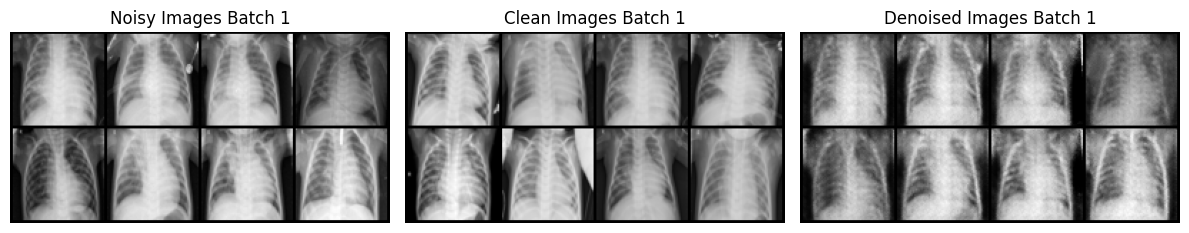

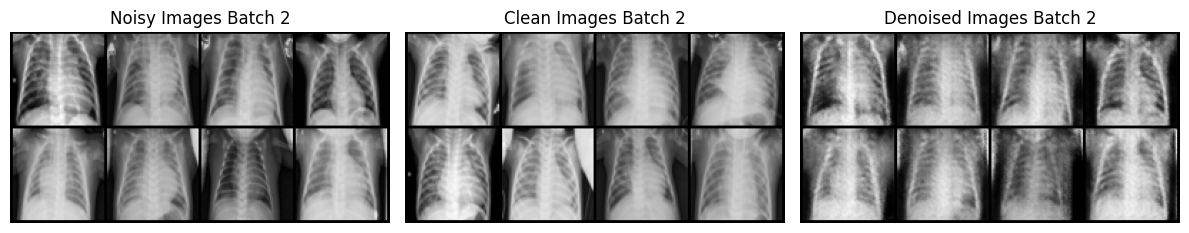

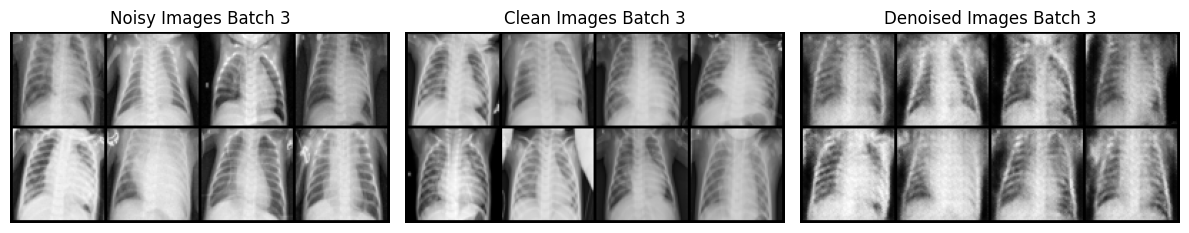

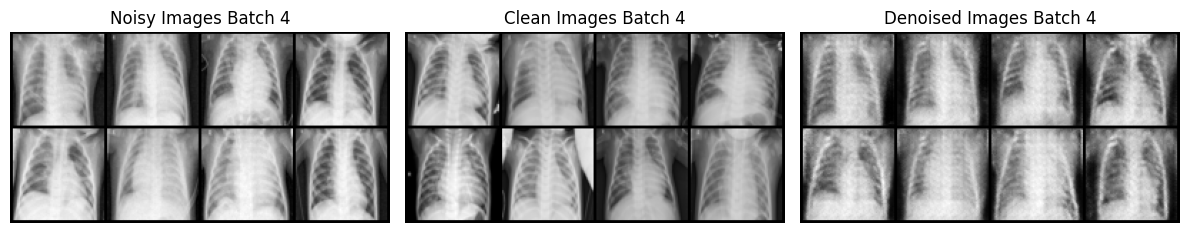

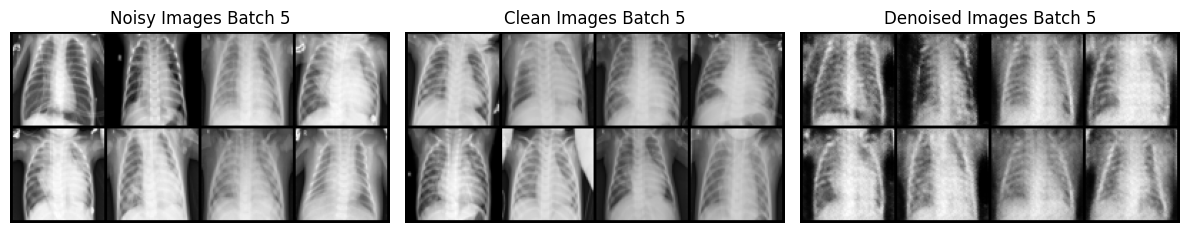

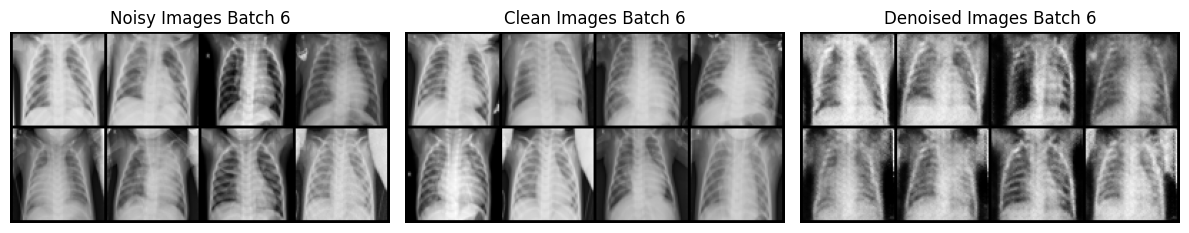

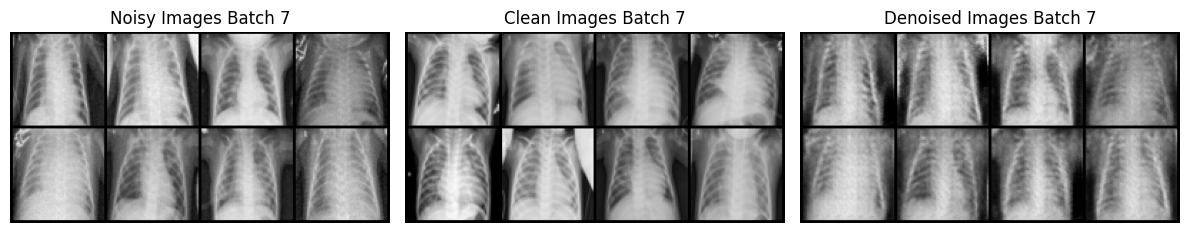

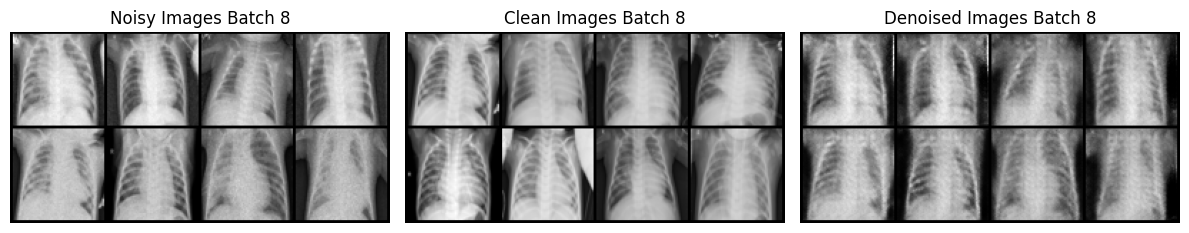

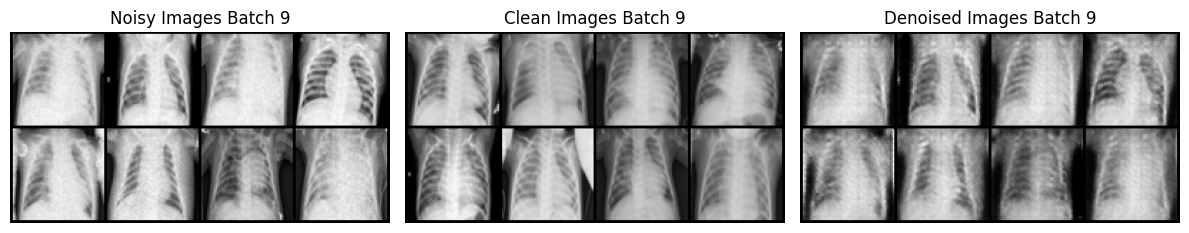

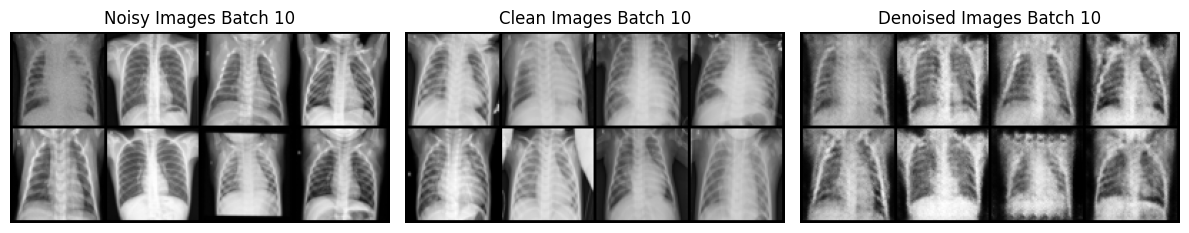

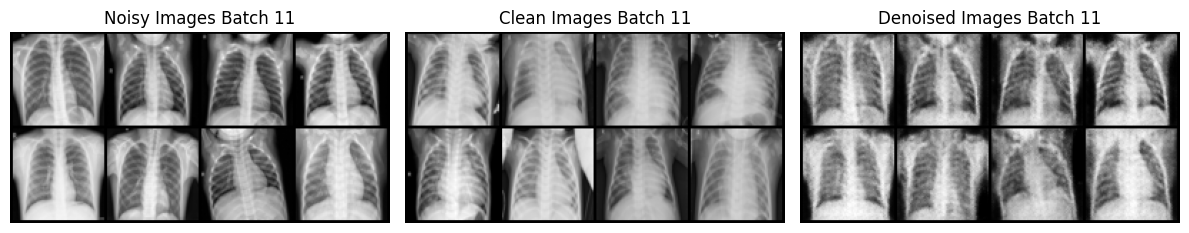

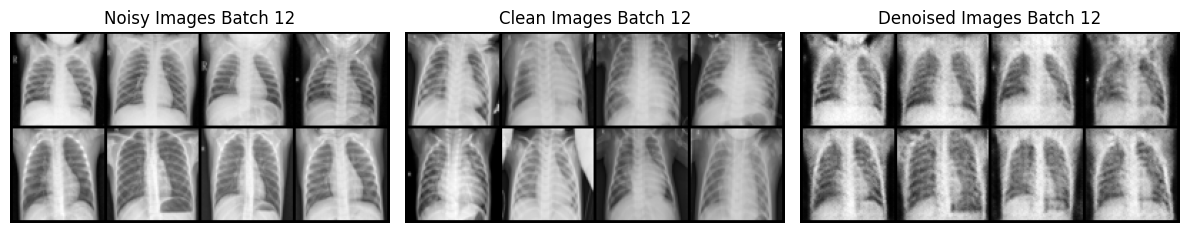

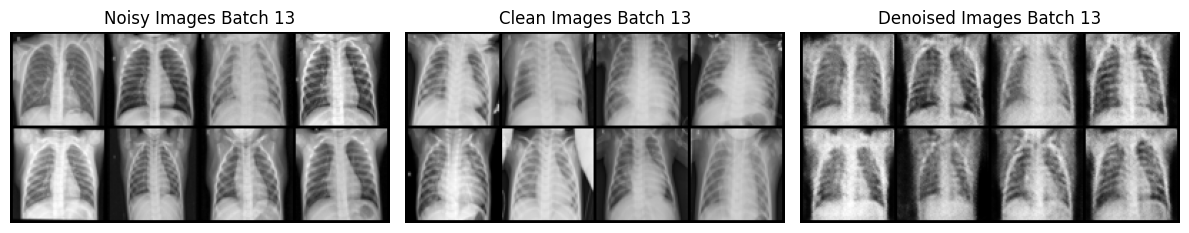

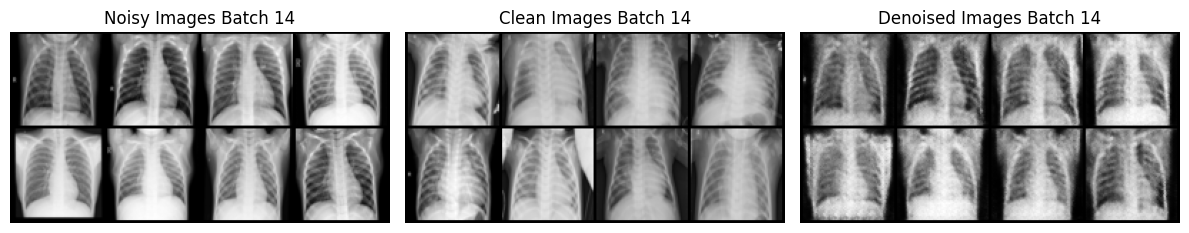

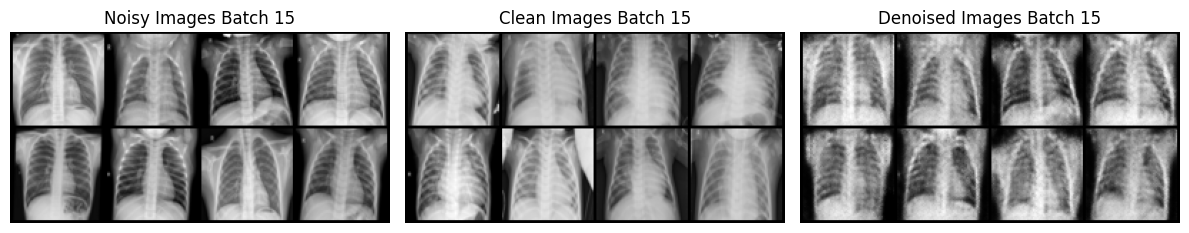

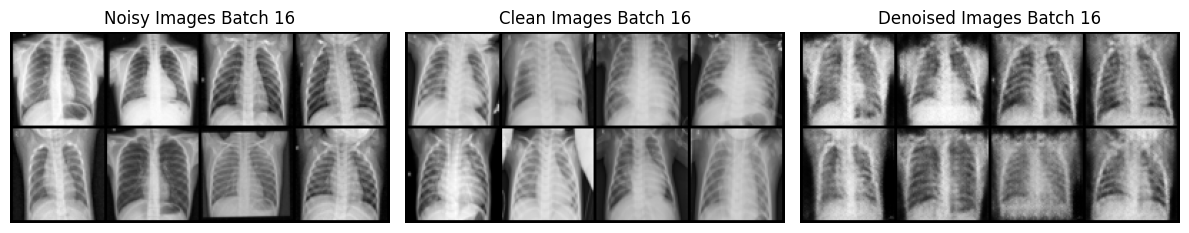

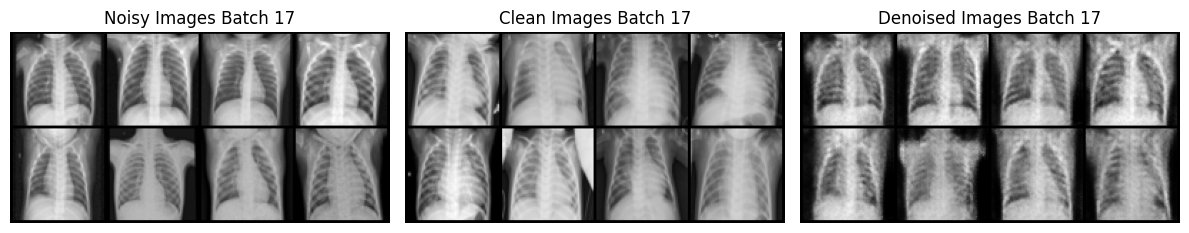

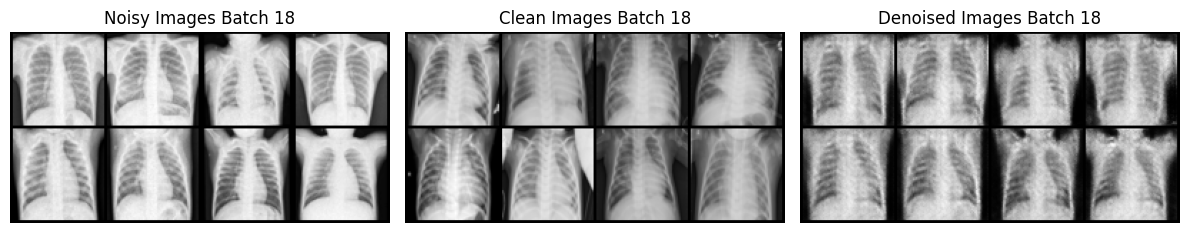

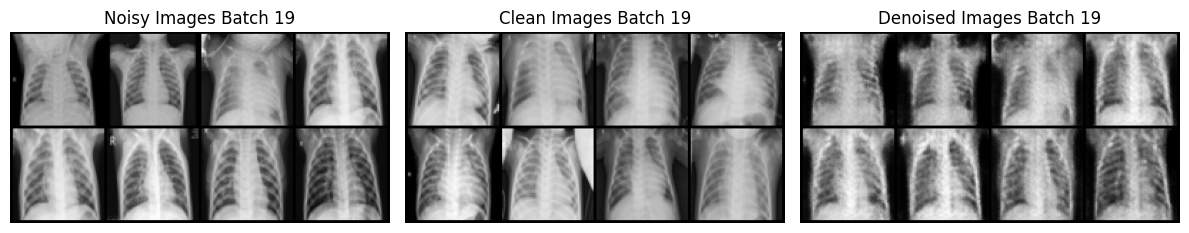

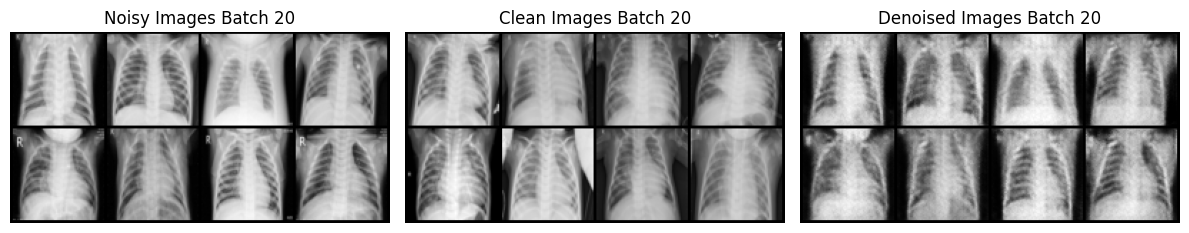

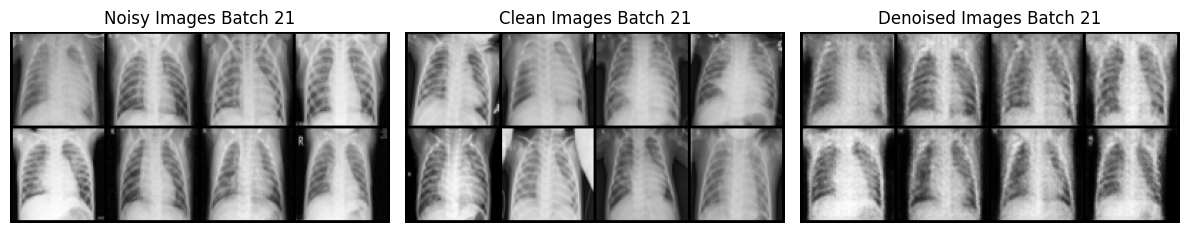

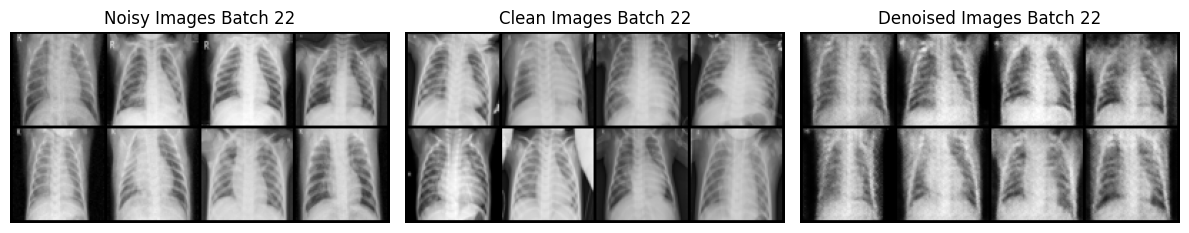

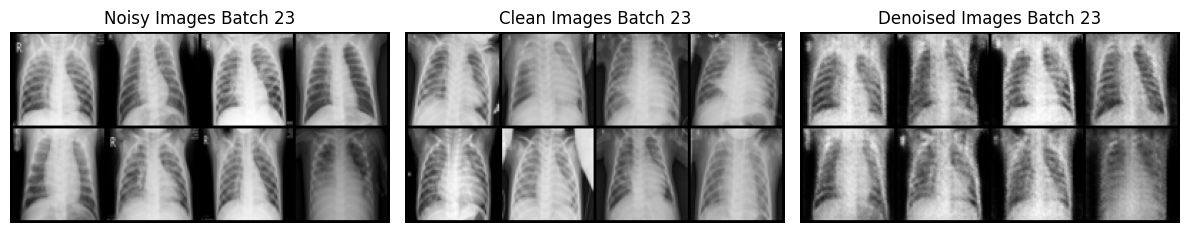

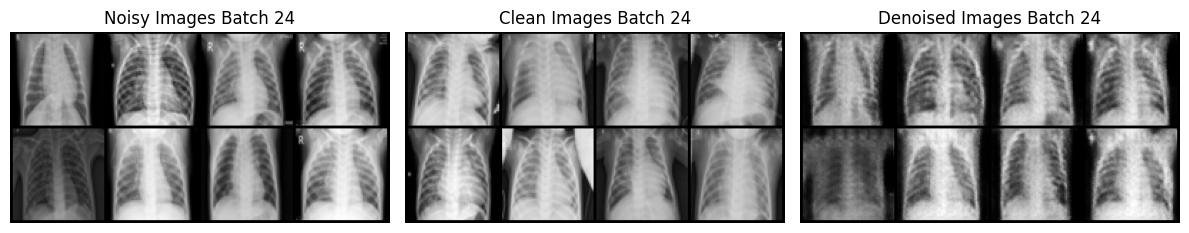

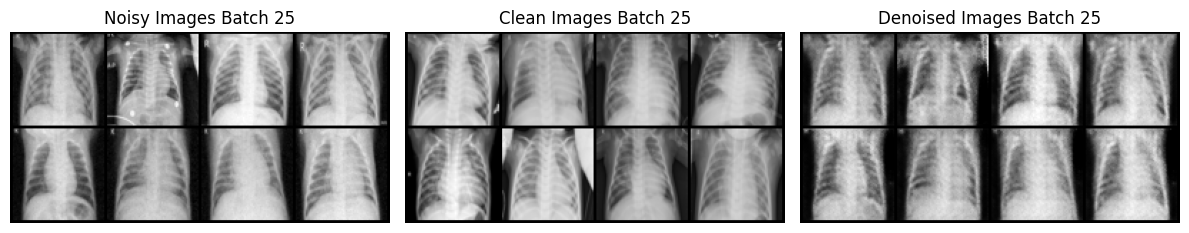

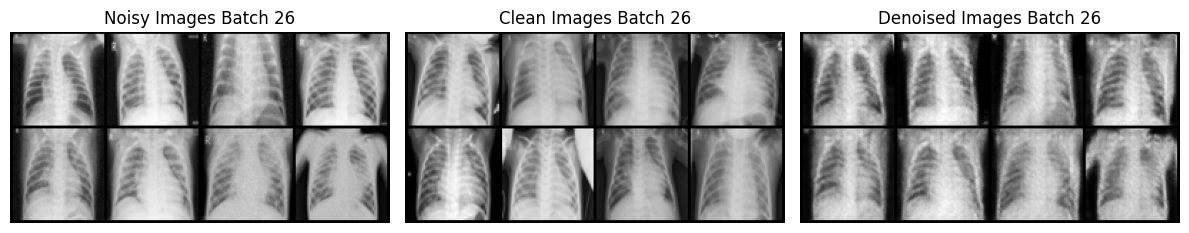

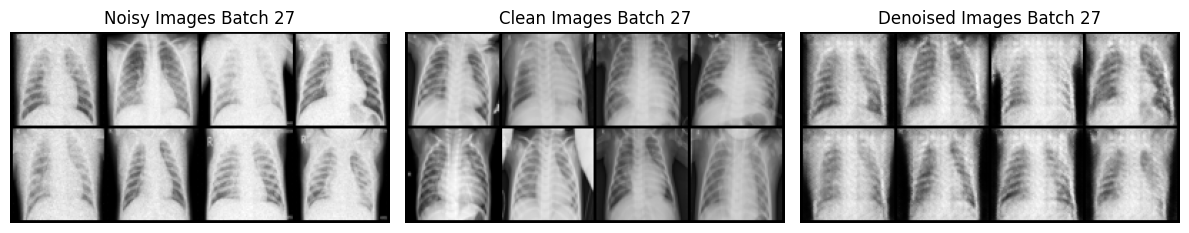

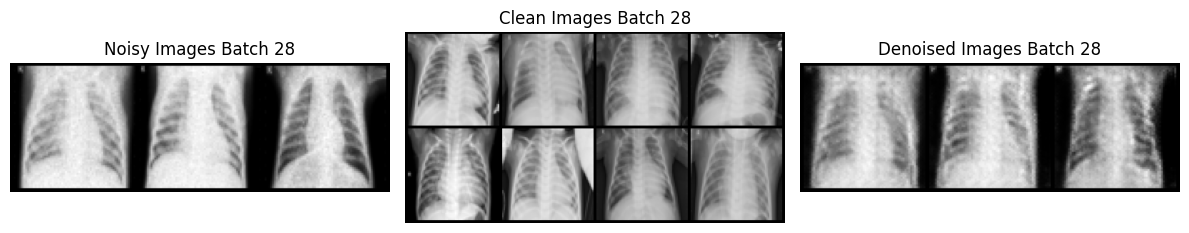

In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt

# Paths to the test images and output directory
test_noisy_root_dir = "/content/drive/MyDrive/CS 415 Computer Vision/CV CS 415/chest_xray/processed_test_noisy"
test_noise_free_root_dir = "/content/drive/MyDrive/CS 415 Computer Vision/CV CS 415/chest_xray/processed_test"
output_dir = "/content/drive/MyDrive/CS 415 Computer Vision/CV CS 415/chest_xray/mitra_gan_test_output_images"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define the transformations (same as training)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize all images to 64x64
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),        # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

# Load test datasets
test_clean_dataset = datasets.ImageFolder(test_noise_free_root_dir, transform=transform)
test_noisy_dataset = datasets.ImageFolder(test_noisy_root_dir, transform=transform)

# DataLoader for batching
batch_size = 16  # You can adjust this based on your memory capacity
test_clean_loader = DataLoader(test_clean_dataset, batch_size=batch_size, shuffle=False)
test_noisy_loader = DataLoader(test_noisy_dataset, batch_size=batch_size, shuffle=False)

# Load the trained generator model
generator.load_state_dict(torch.load("/content/drive/MyDrive/CS 415 Computer Vision/CV CS 415/chest_xray/mitra_gan_models/generator_epoch_25.pth"))
generator.eval()  # Set the generator to evaluation mode

# Loop through the test dataset and generate denoised images
with torch.no_grad():  # No need to compute gradients during inference
    for i, (noisy_images, _) in enumerate(test_noisy_loader):
        noisy_images = noisy_images.to(device)

        # Generate denoised images
        denoised_images = generator(noisy_images)

        # Get corresponding clean images
        clean_images, _ = next(iter(test_clean_loader))
        clean_images = clean_images.to(device)

        # Plot noisy, clean, and denoised images
        plt.figure(figsize=(12, 4))

        # Noisy images
        plt.subplot(1, 3, 1)
        noisy_images_grid = make_grid(noisy_images[:8], nrow=4, normalize=True)
        plt.imshow(np.transpose(noisy_images_grid.cpu().numpy(), (1, 2, 0)))
        plt.title(f"Noisy Images Batch {i+1}")
        plt.axis("off")

        # Clean images
        plt.subplot(1, 3, 2)
        clean_images_grid = make_grid(clean_images[:8], nrow=4, normalize=True)
        plt.imshow(np.transpose(clean_images_grid.cpu().numpy(), (1, 2, 0)))
        plt.title(f"Clean Images Batch {i+1}")
        plt.axis("off")

        # Denoised images
        plt.subplot(1, 3, 3)
        denoised_images_grid = make_grid(denoised_images[:8], nrow=4, normalize=True)
        plt.imshow(np.transpose(denoised_images_grid.cpu().numpy(), (1, 2, 0)))
        plt.title(f"Denoised Images Batch {i+1}")
        plt.axis("off")

        # Save the plot
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"comparison_batch_{i+1}.png"))
        plt.show()

        # Optionally, you can also save the denoised images
        save_image(denoised_images, os.path.join(output_dir, f"denoised_images_batch_{i+1}.png"), nrow=4, normalize=True)


<ipython-input-31-5cb5fbd647eb>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("/content/drive/MyDrive/CS 415 Computer Vision/CV CS 4

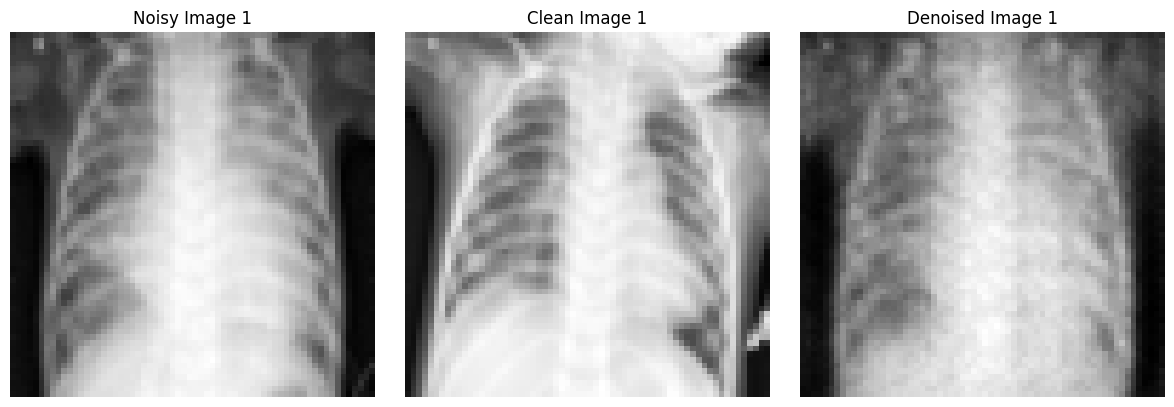

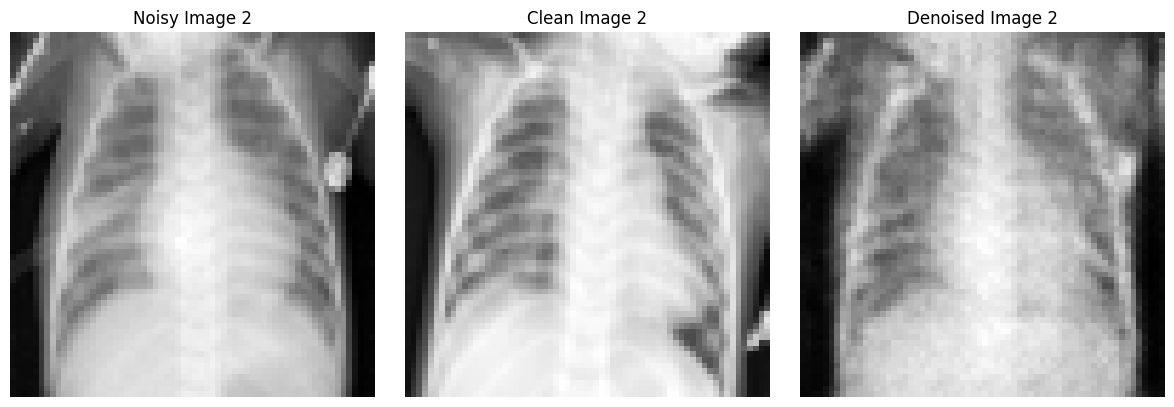

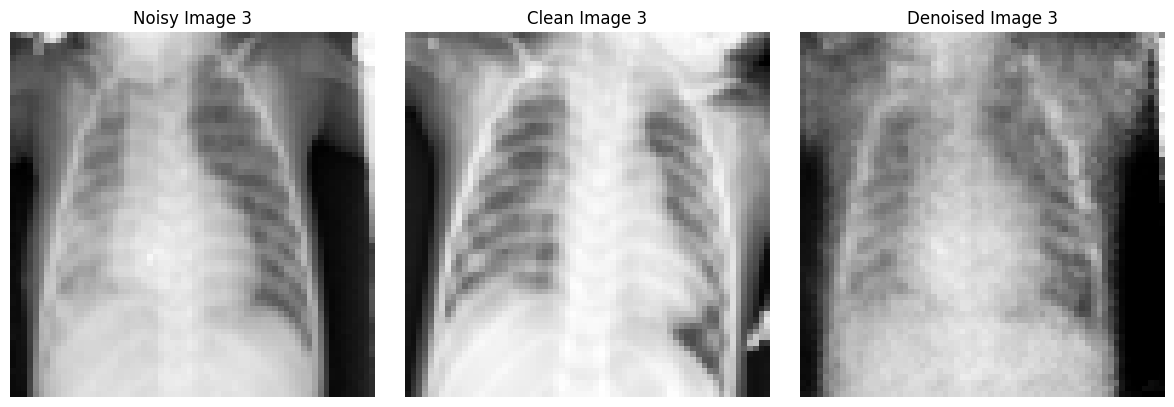

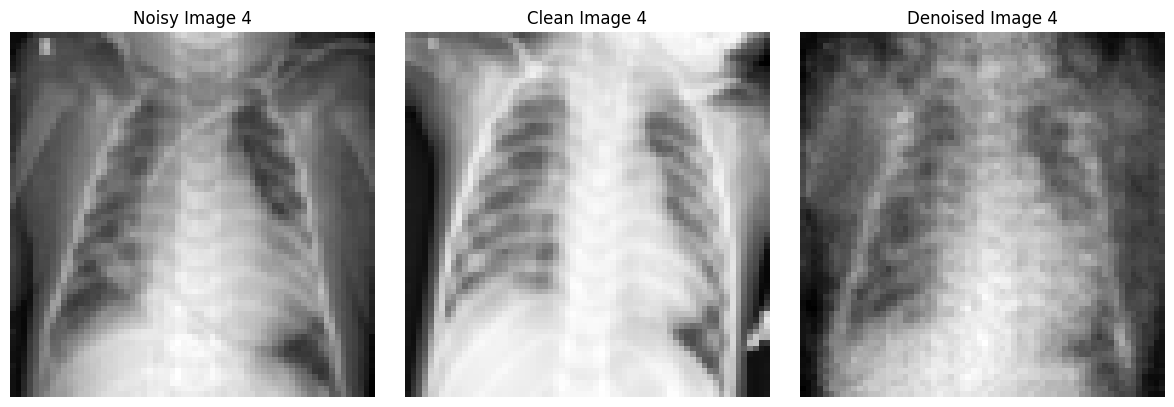

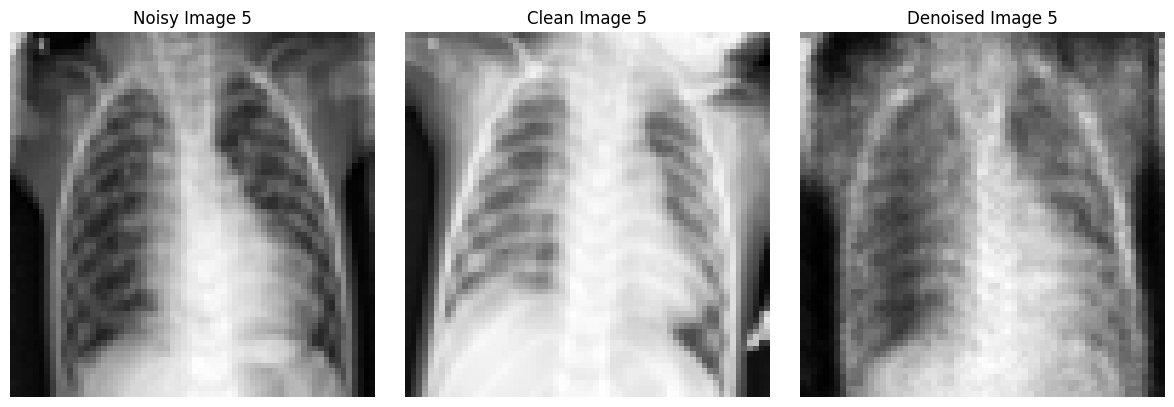

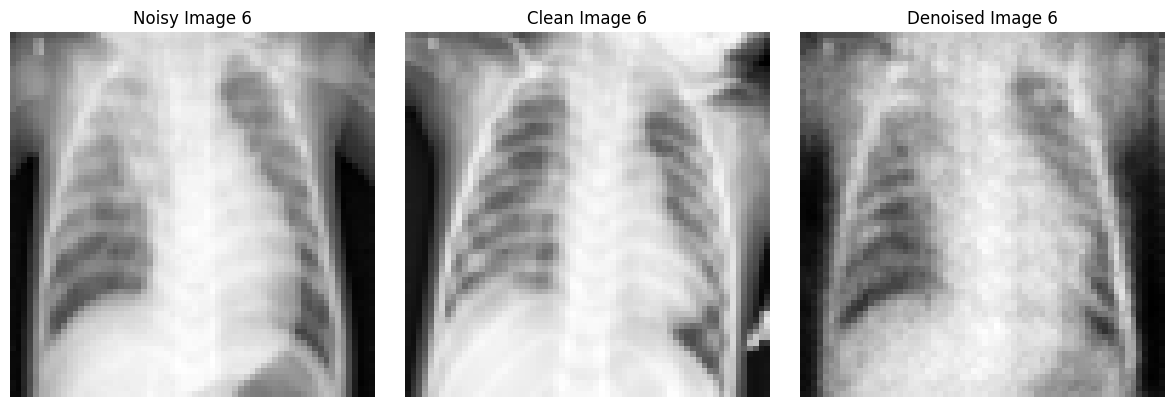

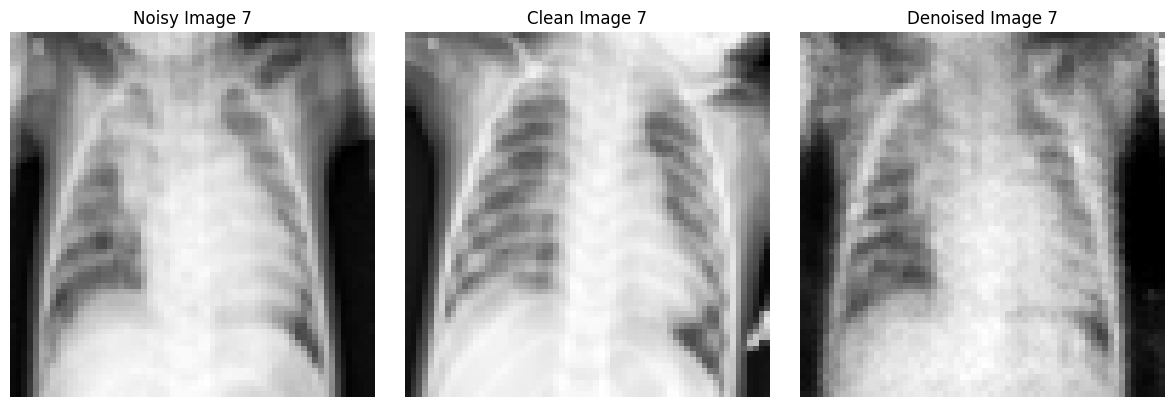

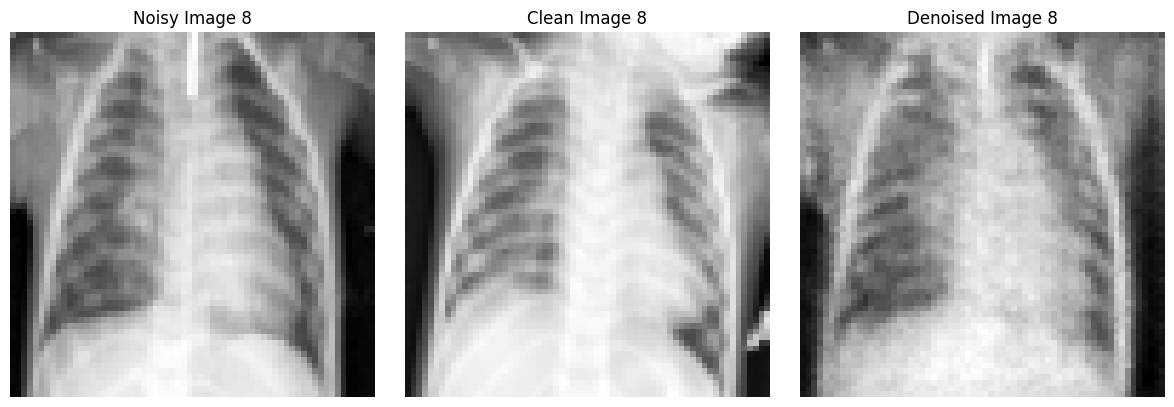

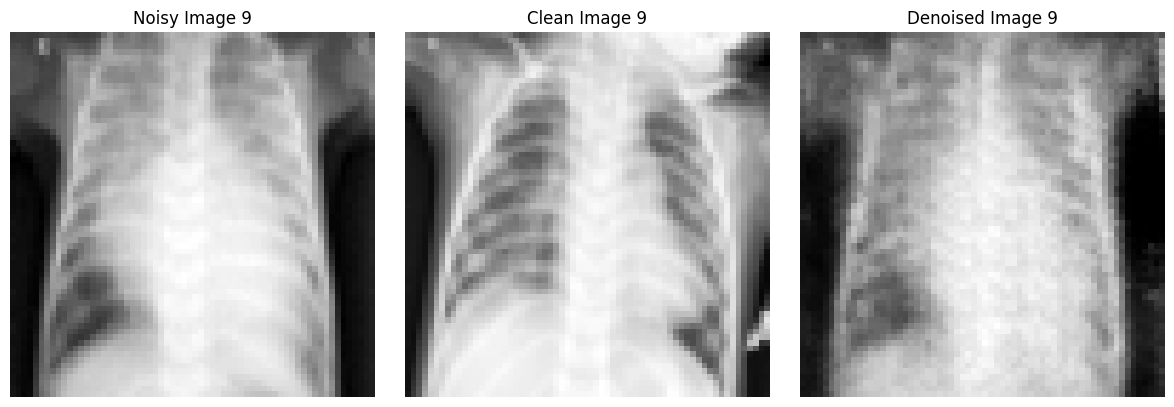

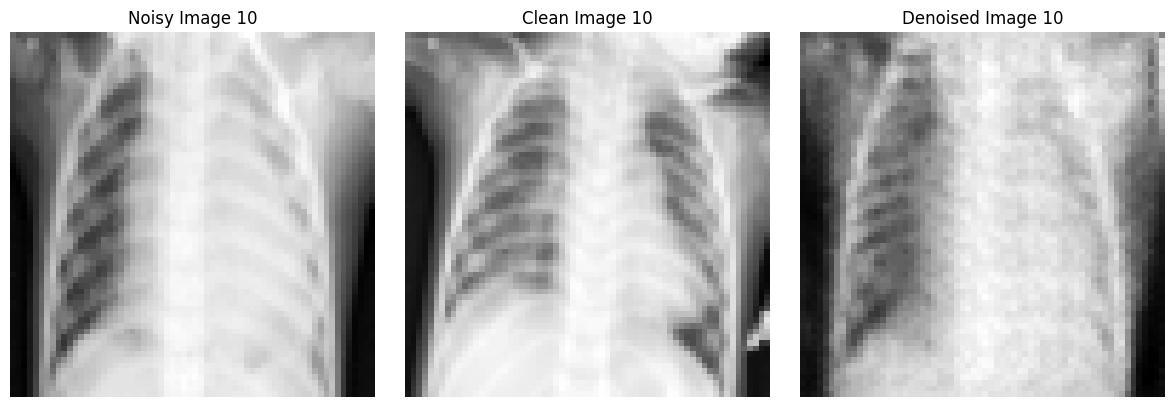

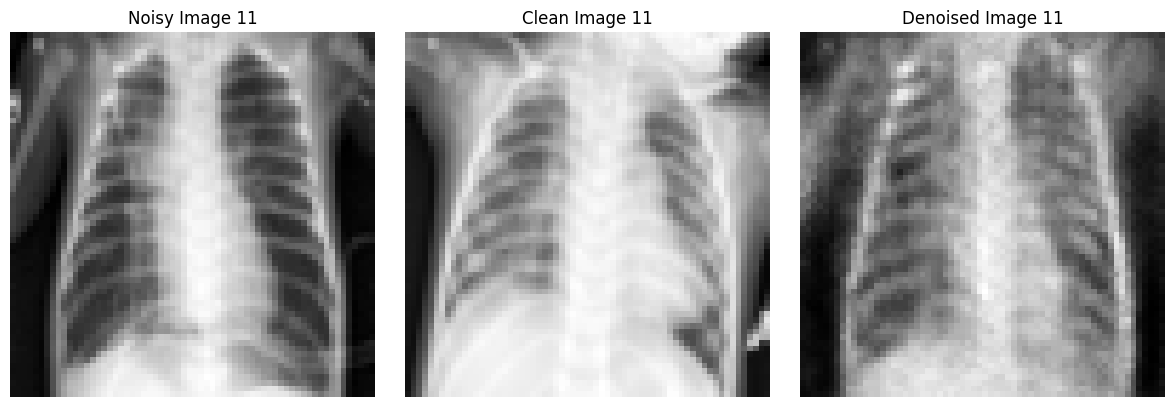

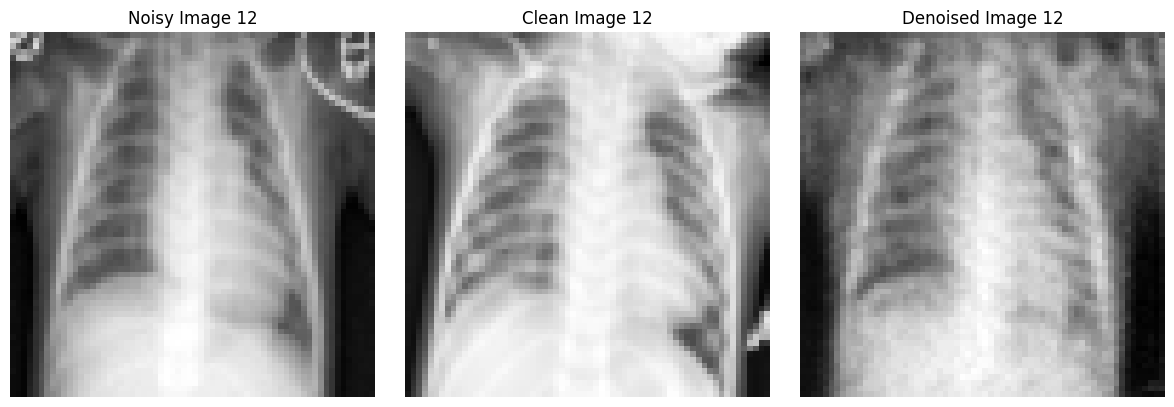

KeyboardInterrupt: 

In [ ]:
## testing without grouping the images
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt

# Paths to the test images and output directory
test_noisy_root_dir = "/content/drive/MyDrive/CS 415 Computer Vision/CV CS 415/chest_xray/processed_test_noisy"
test_noise_free_root_dir = "/content/drive/MyDrive/CS 415 Computer Vision/CV CS 415/chest_xray/processed_test"
output_dir = "/content/drive/MyDrive/CS 415 Computer Vision/CV CS 415/chest_xray/mitra_gan_test_output_images"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define the transformations (same as training)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize all images to 64x64
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),        # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

# Load test datasets
test_clean_dataset = datasets.ImageFolder(test_noise_free_root_dir, transform=transform)
test_noisy_dataset = datasets.ImageFolder(test_noisy_root_dir, transform=transform)

# DataLoader for batching (even though we process individually, we still need DataLoader)
batch_size = 1  # We are processing one image at a time
test_clean_loader = DataLoader(test_clean_dataset, batch_size=batch_size, shuffle=False)
test_noisy_loader = DataLoader(test_noisy_dataset, batch_size=batch_size, shuffle=False)

# Load the trained generator model
generator.load_state_dict(torch.load("/content/drive/MyDrive/CS 415 Computer Vision/CV CS 415/chest_xray/mitra_gan_models/generator_epoch_25.pth"))
generator.eval()  # Set the generator to evaluation mode



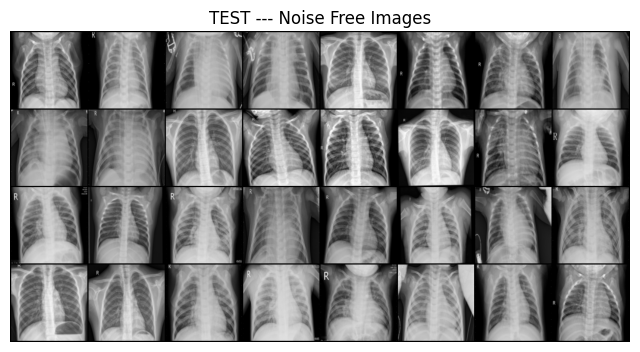

In [ ]:
# Load Test datasets
# Paths to the test images and output directory
test_noisy_root_dir = "/content/drive/MyDrive/CS 415 Computer Vision/CV CS 415/chest_xray/processed_test_noisy"
test_noise_free_root_dir = "/content/drive/MyDrive/CS 415 Computer Vision/CV CS 415/chest_xray/processed_test"


clean_test_dataset = datasets.ImageFolder(test_noise_free_root_dir, transform=transform)
noisy_test_dataset = datasets.ImageFolder(test_noisy_root_dir, transform=transform)

# DataLoaders for batching
test_clean_loader = DataLoader(clean_test_dataset, batch_size=batch_size, shuffle=True)
test_noisy_loader = DataLoader(noisy_test_dataset, batch_size=batch_size, shuffle=True)
# Plot some Noise free images
test_clean_batch = next(iter(test_clean_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("TEST --- Noise Free Images")
plt.imshow(np.transpose(vutils.make_grid(test_clean_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

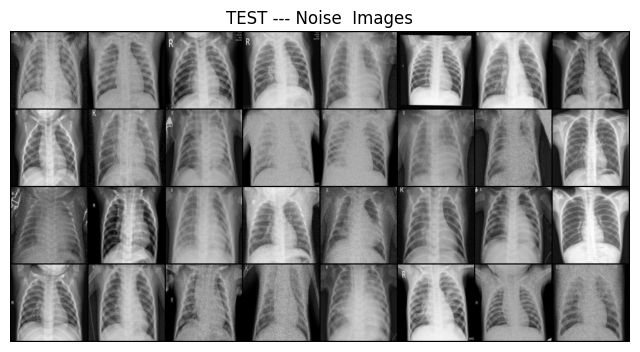

In [ ]:
# Plot some Noise free images
test_noisy_batch = next(iter(test_noisy_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("TEST --- Noise  Images")
plt.imshow(np.transpose(vutils.make_grid(test_noisy_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

<ipython-input-62-b7bb3e165c41>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("/content/drive/MyDrive/CS 415 Computer Vision/CV CS 41

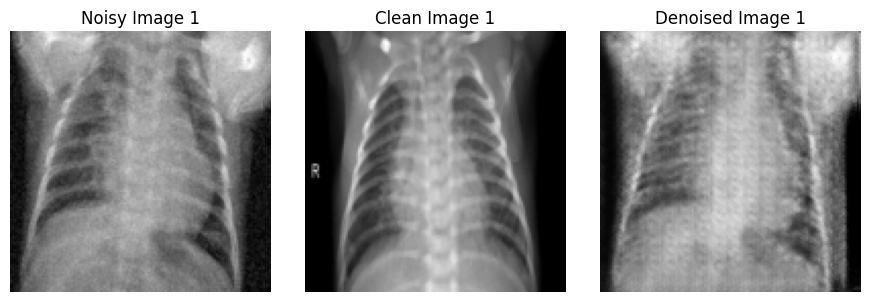

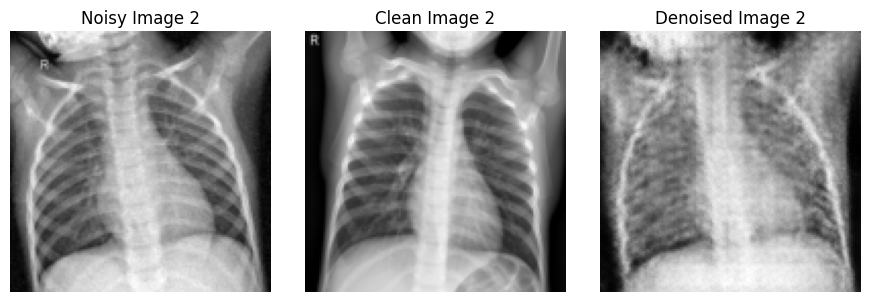

KeyboardInterrupt: 

In [ ]:

# Load the trained generator model
generator.load_state_dict(torch.load("/content/drive/MyDrive/CS 415 Computer Vision/CV CS 415/chest_xray/mitra_gan_models/generator_epoch_25.pth"))
generator.eval()  # Set the generator to evaluation mode

# Loop through the test dataset and generate denoised images
with torch.no_grad():  # No need to compute gradients during inference
    for i, (noisy_images, _) in enumerate(test_noisy_loader):
        noisy_images = noisy_images.to(device)

        # Generate denoised images
        denoised_images = generator(noisy_images)

        # Get corresponding clean images
        clean_images, _ = next(iter(test_clean_loader))
        clean_images = clean_images.to(device)

        # Plot the noisy, clean, and denoised images together
        plt.figure(figsize=(9, 3))

        # Noisy image (take the first image from the batch)
        plt.subplot(1, 3, 1)
        plt.imshow(np.transpose(noisy_images[0].cpu().numpy(), (1, 2, 0)), cmap='gray')  # Extract the first image
        plt.title(f"Noisy Image {i+1}")
        plt.axis("off")

        # Clean image (take the first image from the batch)
        plt.subplot(1, 3, 2)
        plt.imshow(np.transpose(clean_images[0].cpu().numpy(), (1, 2, 0)), cmap='gray')  # Extract the first image
        plt.title(f"Clean Image {i+1}")
        plt.axis("off")

        # Denoised image (take the first image from the batch)
        plt.subplot(1, 3, 3)
        plt.imshow(np.transpose(denoised_images[0].cpu().numpy(), (1, 2, 0)), cmap='gray')  # Extract the first image
        plt.title(f"Denoised Image {i+1}")
        plt.axis("off")

        # Save the combined plot
        plt.tight_layout()
        #plt.savefig(os.path.join(output_dir, f"comparison_image_{i+1}.png"))
        plt.show()
        plt.close()


In [ ]:
## ** testing with psnr & ssim ** ##
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim


output_dir = "/content/drive/MyDrive/CS 415 Computer Vision/CV CS 415/chest_xray/MITRA_gan_test_output_images"
# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Function to calculate PSNR (after scaling from [-1, 1] to [0, 1])
def calculate_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)  # Mean Squared Error
    if mse == 0:
        return 100  # No difference between the images
    max_pixel = 1.0  # Max pixel value for normalized images [0, 1]
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr.item()

# Variables to store the cumulative PSNR and SSIM
total_psnr = 0
total_ssim = 0
num_images = 0

# Load the trained generator model
generator.load_state_dict(torch.load("/content/drive/MyDrive/CS 415 Computer Vision/CV CS 415/chest_xray/mitra_gan_models/generator_epoch_25.pth"))
generator.eval()  # Set the generator to evaluation mode

# Loop through the test dataset and generate denoised images
with torch.no_grad():  # No need to compute gradients during inference
    for i, (noisy_images, _) in enumerate(test_noisy_loader):
        noisy_images = noisy_images.to(device)

        # Generate denoised images
        denoised_images = generator(noisy_images)

        # Get corresponding clean images
        clean_images, _ = next(iter(test_clean_loader))
        clean_images = clean_images.to(device)

        # Calculate PSNR and SSIM for each image in the batch
        for j in range(noisy_images.size(0)):
            # Convert the tensors to numpy arrays and rescale from [-1, 1] to [0, 1]
            noisy_image_np = (noisy_images[j].cpu().numpy().transpose(1, 2, 0) + 1) / 2
            clean_image_np = (clean_images[j].cpu().numpy().transpose(1, 2, 0) + 1) / 2
            denoised_image_np = (denoised_images[j].cpu().numpy().transpose(1, 2, 0) + 1) / 2

            # Calculate PSNR
            psnr_value = calculate_psnr(torch.tensor(noisy_image_np), torch.tensor(clean_image_np))
            total_psnr += psnr_value

            # Calculate SSIM
            # Dynamically set win_size to a value less than or equal to the smaller dimension of the image
            win_size = min(clean_image_np.shape[0], clean_image_np.shape[1], 7)  # Ensure win_size is at most 7x7

            # Calculate SSIM
            ssim_value = ssim(clean_image_np, denoised_image_np, data_range=denoised_image_np.max() - denoised_image_np.min(), win_size=3, channel_axis=-1)
            total_ssim += ssim_value

            num_images += 1

        # Plot the noisy, clean, and denoised images together
        plt.figure(figsize=(9, 3))

        # Noisy image (take the first image from the batch)
        plt.subplot(1, 3, 1)
        plt.imshow(np.transpose(noisy_images[0].cpu().numpy(), (1, 2, 0)), cmap='gray')  # Extract the first image
        plt.title(f"Noisy Image {i+1}")
        plt.axis("off")

        # Clean image (take the first image from the batch)
        plt.subplot(1, 3, 2)
        plt.imshow(np.transpose(clean_images[0].cpu().numpy(), (1, 2, 0)), cmap='gray')  # Extract the first image
        plt.title(f"Clean Image {i+1}")
        plt.axis("off")

        # Denoised image (take the first image from the batch)
        plt.subplot(1, 3, 3)
        plt.imshow(np.transpose(denoised_images[0].cpu().numpy(), (1, 2, 0)), cmap='gray')  # Extract the first image
        plt.title(f"Denoised Image {i+1}")
        plt.axis("off")

        # Save the combined plot
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"comparison_image_{i+1}.png"))
        #plt.show()
        plt.close()

# Calculate the average PSNR and SSIM
avg_psnr = total_psnr / num_images
avg_ssim = total_ssim / num_images

print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")


<ipython-input-72-1242c7a6803c>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("/content/drive/MyDrive/CS 415 Computer Vision/CV CS 4

Average PSNR: 14.21 dB
Average SSIM: 0.3421
